# Week 4: Gaussian Mixture Model

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. (optional) Implement GMM algorithm by Numpy.

In [97]:
from matplotlib.colors import ListedColormap
from matplotlib import patches

from scipy.stats import multivariate_normal
import warnings
warnings.filterwarnings('ignore')

In [98]:
class Gaussian_Mixture(object):
    """gaussian mixture model - vectorized implementation"""
    
    def __init__(self, n_components = 3, max_iterations = 100, tol = 0.001):
        self.n_components = n_components
        self.max_iterations = max_iterations
        self.tol = tol
        self.means = None
        self.covariances = None
        self.log_likelihoods = None
        
    
    def fit(self, X, y = None):
        n,d = X.shape # n = datapoints, d = features
        k = self.n_components  ##K number of clusters
        # randomly initialize the starting means
        mu = X[np.random.choice(n,k,replace = False)]
        
        # initialize a covariance matrix for each gaussian
        Sigma  = [np.eye(d)] * k
        
        # initialize the probability for each gaussian pi
        pi = np.array([1 / k] * k)
        
        # initialize responsibility matrix: n points for each gaussian 
        W = np.zeros((n,k))
        
        # initialize list of log_likelihoods
        log_likelihoods = []
        
        # lambda function for gaussian pdf
        P = lambda m, s: multivariate_normal.pdf(X, mean = m, cov = s)
        
        #===============================================================#
        
        while len(log_likelihoods) < self.max_iterations:
            
            ## E step
            
            # nominator of responsibilities: j is the j-th gaussian 
            for j in range(k):
                W[:, j] = pi[j] * P(mu[j],Sigma[j])
                
            # log likelihood computation (same as nominator of responsibilities):
            l = np.sum(np.log(np.sum(W, axis = 1)))
            
            # store log likelihood in list
            log_likelihoods.append(l)
            
            # compute W matrix by dividing by denominator (the sum of long j)
            W = (W.T / W.sum(axis = 1)).T
            
            # sum of w^i entries along j (used for parameter updates)
            
            # these are the soft weighted number of datapoints belong to each gaussian
            W_s = np.sum(W, axis = 0)
            
            ## M step
            for j in range(k):
                # update means
                mu[j] = (1. / W_s[j]) * np.sum(W[:, j] * X.T, axis = 1).T
                
                # update covariances
                Sigma[j] = ((W[:,j] * ((X - mu[j]).T))@ (X - mu[j])) / W_s[j]
                
                # update probabilities of each gaussian
                pi[j] = W_s[j] / n
            
            # check for convergence
            if len(log_likelihoods) < 2: continue
            if np.abs(l - log_likelihoods[-2]) < self.tol: break
        
        self.means = mu
        self.covariances = Sigma 
        self.log_likelihoods = log_likelihoods 
        
    def predict_proba(self, x0):
        probs = np.array([multivariate_normal.pdf(x0, mean = self.means[j], sov = self.covariances[j]) for j in range(self.n_components)])
        return probs
    
    def predict(self, x0):
        probs = np.array([multivariate_normal.pdf(x0, mean = self.means[j], cov = self.covariances[j]) for j in range(self.n_components)])
        return np.argmax(probs, axis = 0)
    
    

# 2. Create at least three toy dataset (https://scikit-learn.org/stable/datasets/sample_generators.html), then apply GMM algorithm built in the first question or used sklearn library? Try different number of cluster to see how the result change? Draw the elbow and Silhouette score for the above dataset.

In [102]:
from sklearn import datasets
from sklearn.mixture import GaussianMixture
#from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from matplotlib.patches import Ellipse
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(color_codes = True)
color_list = ['red','yellow','blue','aqua','green','coral']

In [103]:
def draw_ellipse(position, covariance, ax, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    # Draw the Ellipse
    for nsig in range(2, 3):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))

def plot_gmm(gmm, X, ax):
    ax = ax
    labels = gmm.fit(X).predict(X)
    sns.scatterplot(X[:, 0], X[:, 1], hue=labels, ax= ax, s=40, palette='deep', legend= False, alpha=0.5)


    i = 0
    for pos, covar in zip(gmm.means_, gmm.covariances_):
        draw_ellipse(pos, covar, ax= ax,edgecolor = color_list[i], facecolor= 'none', alpha= 1)
        i += 1

def plot_score(X):
    n_components = np.arange(2, 21)
    models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X)
          for n in n_components]
    fig, ax = plt.subplots( 1,2, figsize=(20, 4))
    ax[0].plot(n_components, [m.bic(X) for m in models], label='BIC')
    ax[0].plot(n_components, [m.aic(X) for m in models], label='AIC')

    ax[0].set_xlabel('n_components')
    ax[0].set_title('Elbow Method')
    ax[0].set_xticks(n_components, labels= n_components)

    ax[1].plot(n_components, [silhouette_score(X,m.predict(X)) for m in models])
    ax[1].set_xlabel('n_components')
    ax[1].set_title('Silhouette Score')
    ax[1].set_xticks(n_components, labels= n_components)

# 3 toy datasets

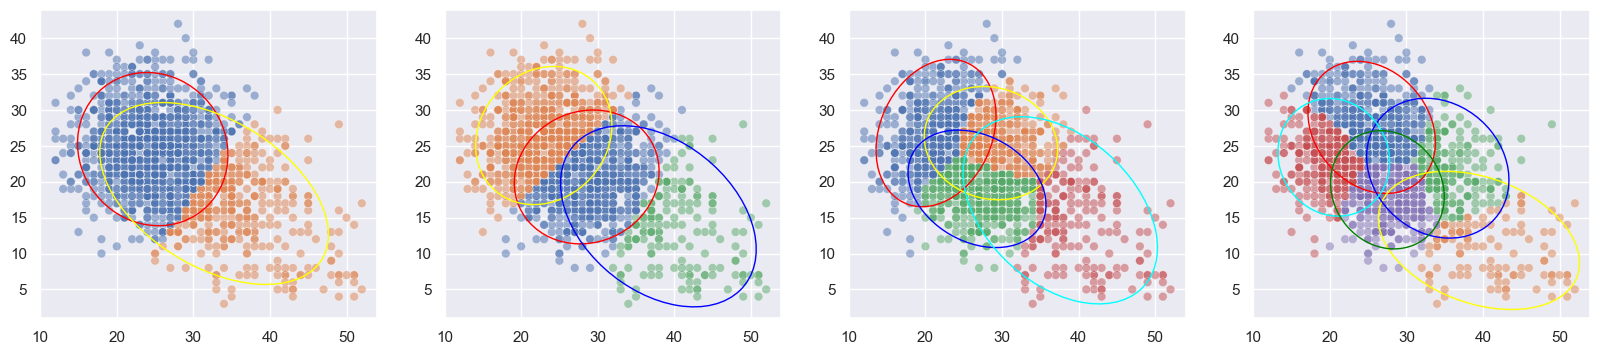

In [104]:
# 1
K = [2, 3, 4, 5]

X, y = datasets.make_multilabel_classification(n_samples=1500, n_features=2, random_state=0)

fig, ax = plt.subplots( 1,4, figsize=(20, 4))
for i, K in enumerate(K):
    k = GaussianMixture(K)
    plot_gmm(k, X, ax[i])

plt.show()

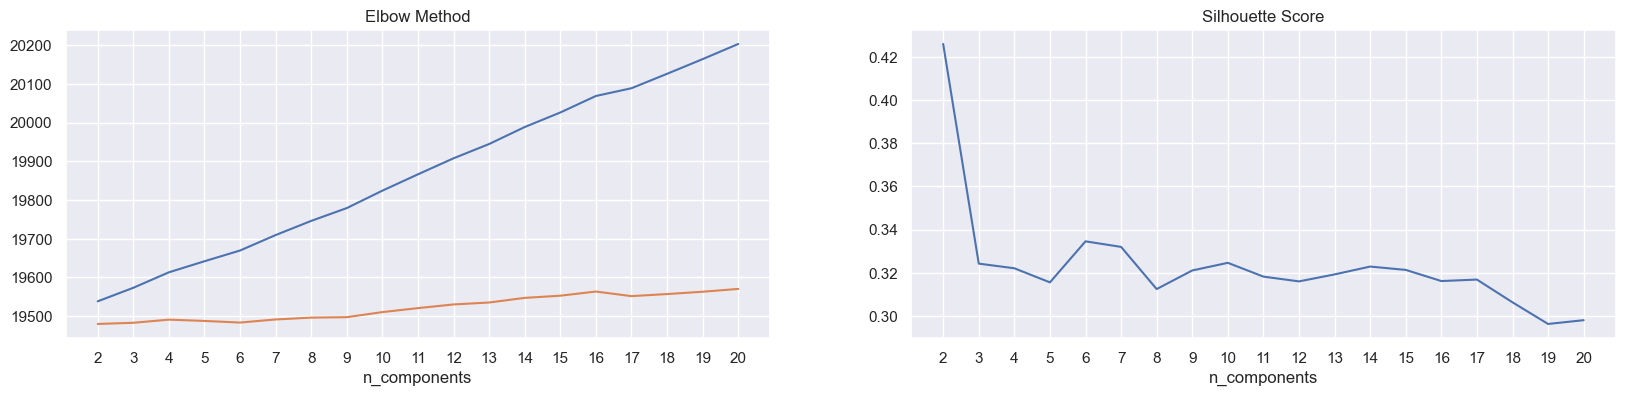

In [105]:
plot_score(X)

In [106]:
#2


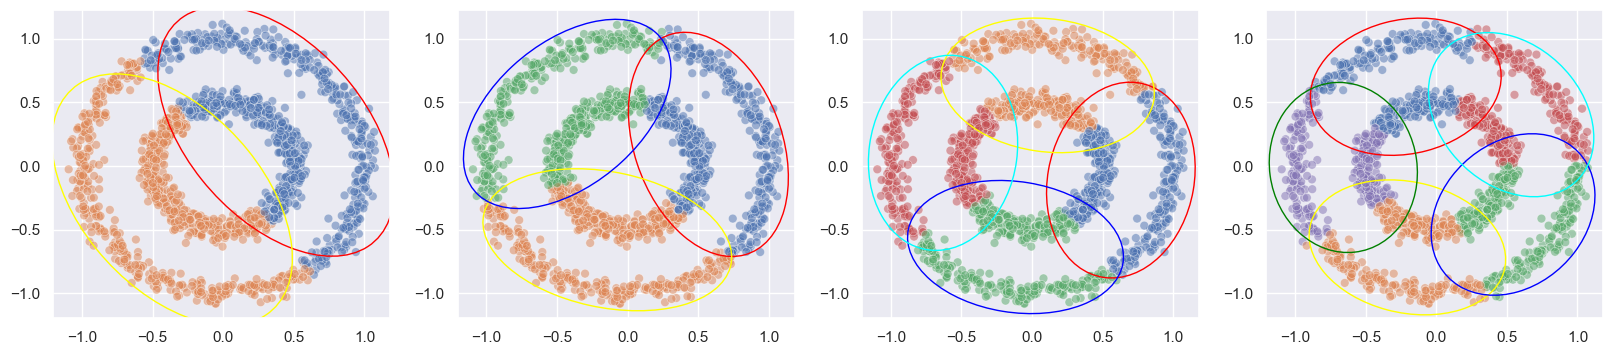

In [107]:
X, y = datasets.make_circles(n_samples=1500, factor=0.5, noise=0.05, random_state=0)
fig, ax = plt.subplots( 1,4, figsize=(20, 4))
K = [2, 3, 4, 5]
for i, K in enumerate(K):
    k = GaussianMixture(K)
    plot_gmm(k, X, ax[i])
plt.show()

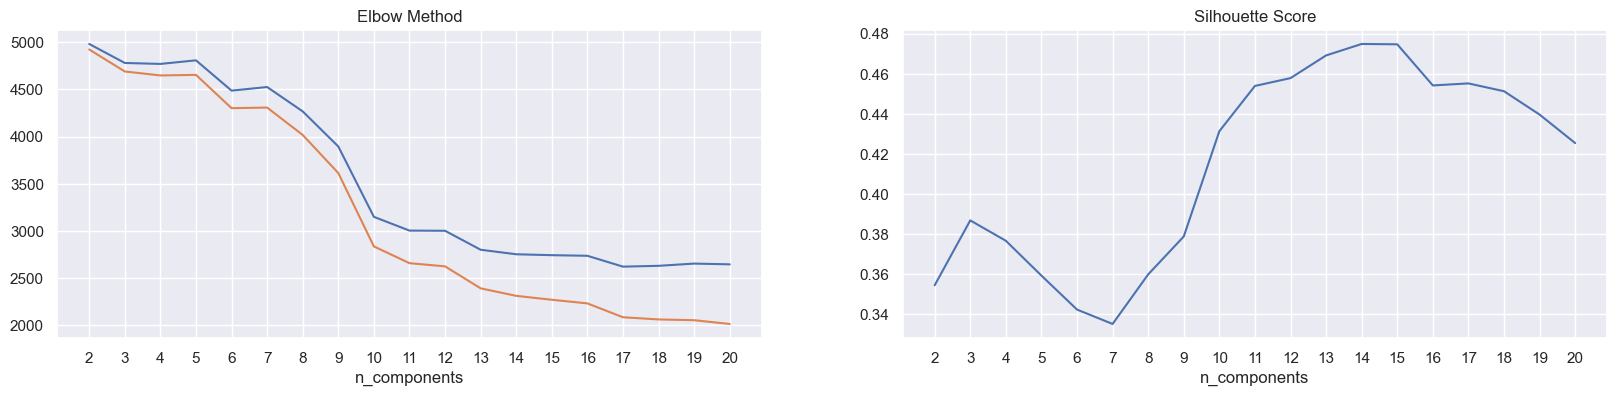

In [108]:
plot_score(X)

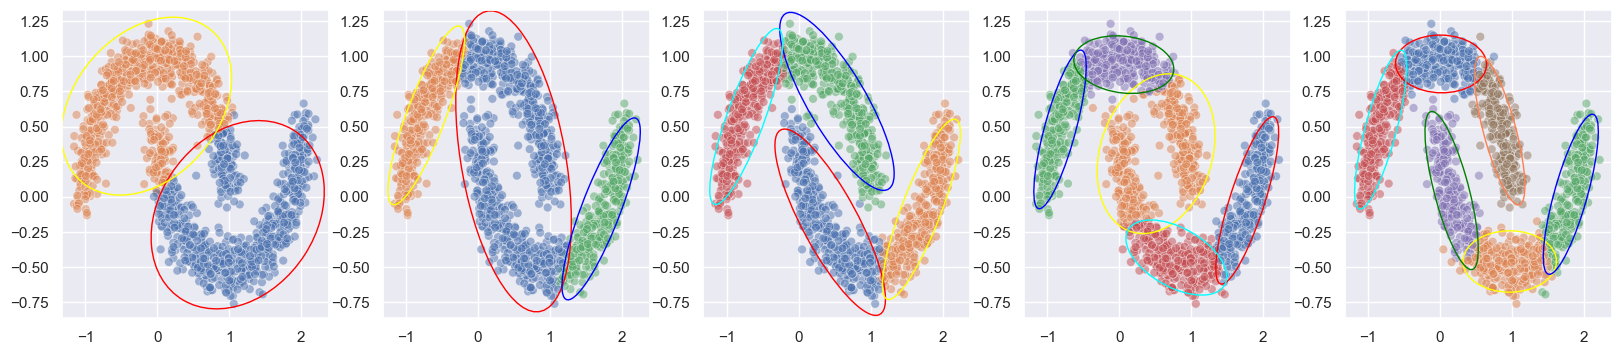

In [109]:
# 3
K = [2, 3, 4, 5, 6]
X, y = datasets.make_moons(1500, noise=.1, random_state=0)

fig, ax = plt.subplots( 1,5, figsize=(20, 4))
for i, K in enumerate(K):
    k = GaussianMixture(K)
    plot_gmm(k, X, ax[i])

plt.show()


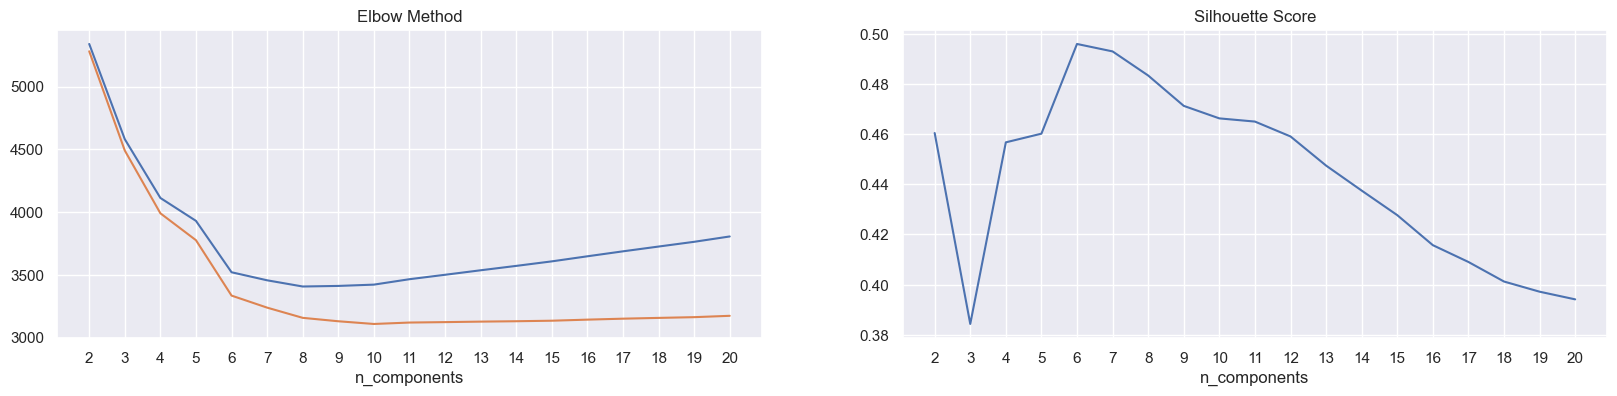

In [110]:
plot_score(X)

# EX3: 

- We like using K-means clustering in many situations because it is easy to apply and converge quickly, such that it is computationally faster than several other EM algorithms even with a large number of variables.
- However, K-Means is not good at finding clusters of different sizes, shapes, and densities

- GMM works very well on the data of different size and densities, ALSO, it is very fast
- Yet, the result is not stable, that is, the clustering is a little different each time. The reason is that it is completely exploratory and sensitive to violations of distributional assumptions.

===============================================================================================================


Advantages of K-Means:

1. Running Time

2. Better for high dimensional data.

3. Easy to interpret and Implement.

Disadvantages of K-Means:

1. Assumes the clusters as spherical, so does not work efficiently with complex geometrical shaped data(Mostly Non-Linear)

2. Hard Assignment might lead to mis grouping.

Guassian Mixture:

Instead of Hard assgning data points to a cluster, if we are uncertain about the data points where they belong or to which group, we use this method. It uses probability of a sample to determine the feasibility of it belonging to a cluster.

Advantages:

1. Does not assume clusters to be of any geometry. Works well with non-linear geometric distributions as well.

2. Does not bias the cluster sizes to have specific structures as does by K-Means (Circular).

Disadvantages:

1. Uses all the components it has access to, so initialization of clusters will be difficult when dimensionality of data is high.

2. Difficult to interpret.

# EX4: Find 3 examples that GMM is better than kmeans

In [118]:
iris = datasets.load_iris()
x  = iris.data
y = iris.target
X = pd.DataFrame(x)
Y = pd.DataFrame(y)

In [119]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaler.fit(X)
X_scaled_array = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled_array, columns = X.columns)
X_scaled.sample(5)

,0,1,2,3
39,-0.900681,0.788808,-1.283389,-1.315444
147,0.795669,-0.131979,0.819596,1.053935
14,-0.052506,2.169988,-1.453901,-1.315444
88,-0.294842,-0.131979,0.194384,0.132510
136,0.553333,0.788808,1.046945,1.580464


In [120]:
# Kmeans
from sklearn.cluster import KMeans
nclusters = 3 # this is the k in kmeans
seed = 0
km = KMeans(n_clusters=nclusters, random_state=seed)
km.fit(X_scaled)
# predict the cluster for each data point
y_cluster_kmeans = km.predict(X_scaled)
y_cluster_kmeans

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2,
       2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0], dtype=int32)

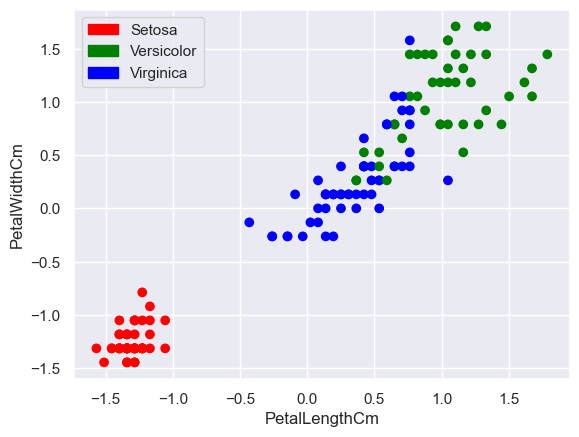

In [121]:
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Setosa')
green_patch = mpatches.Patch(color='green', label='Versicolor')
blue_patch = mpatches.Patch(color='blue', label='Virginica')
colors = np.array(['blue', 'red', 'green'])
plt.scatter(X_scaled.iloc[:, 2],X_scaled.iloc[:, 3],c=colors[y_cluster_kmeans])
plt.xlabel("PetalLengthCm")
plt.ylabel("PetalWidthCm")
plt.legend(handles=[red_patch, green_patch, blue_patch])
plt.show()

In [123]:
from sklearn import metrics
score = metrics.silhouette_score(X_scaled, y_cluster_kmeans)
score


0.45994823920518635

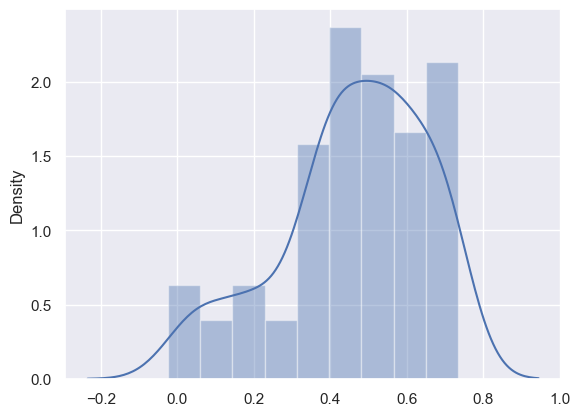

In [124]:
scores = metrics.silhouette_samples(X_scaled, y_cluster_kmeans)
sns.distplot(scores);


In [125]:
from sklearn.metrics.cluster import adjusted_rand_score
score = adjusted_rand_score(y, y_cluster_kmeans) 
score

0.6201351808870379

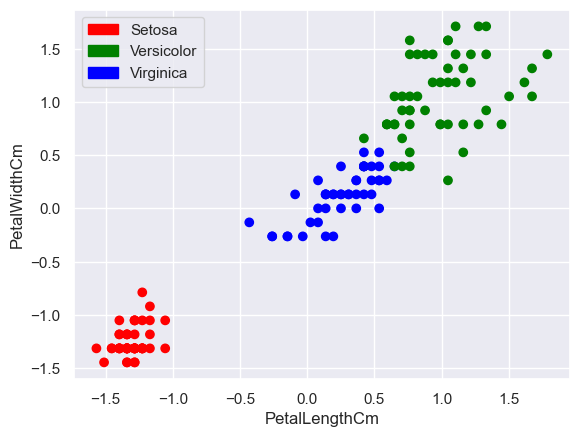

In [127]:
# gmm
gmm = GaussianMixture(n_components=nclusters)
gmm.fit(X_scaled)
# predict the cluster for each data point
y_cluster_gmm = gmm.predict(X_scaled)
y_cluster_gmm

red_patch = mpatches.Patch(color='red', label='Setosa')
green_patch = mpatches.Patch(color='green', label='Versicolor')
blue_patch = mpatches.Patch(color='blue', label='Virginica')
colors = np.array(['blue', 'red', 'green'])
plt.scatter(X_scaled.iloc[:, 2],X_scaled.iloc[:, 3],c=colors[y_cluster_gmm])
plt.xlabel("PetalLengthCm")
plt.ylabel("PetalWidthCm")
plt.legend(handles=[red_patch, green_patch, blue_patch])
plt.show()

In [129]:
score = metrics.silhouette_score(X_scaled, y_cluster_gmm)
score

0.37416491866541235

In [131]:
score = adjusted_rand_score(y, y_cluster_gmm)
score
# The Gaussian mixture model has an adjusted rand score of 0.9. It gives a better fit of clustering.

0.9038742317748124